In [2]:
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import re

In [3]:
quora_df = pd.read_csv('dataset/royal_family_quora_comments_dataset.csv')
quora_df.head()
quora_df.info()

with open('dataset/profane_words.txt', 'r') as file:
    profane_words = [line for line in file.read().splitlines() if line]
print("\nprofane_words:", profane_words)
print("number of profane words:",len(profane_words))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Quora Question  6 non-null      object 
 1   Reply/Comment   164 non-null    object 
 2   Classification  164 non-null    object 
 3   Label           164 non-null    float64
 4   Intensity       164 non-null    object 
dtypes: float64(1), object(4)
memory usage: 14.9+ KB

profane_words: ['abbo', 'abo', 'abortion', 'abuse', 'addict', 'addicts', 'adult', 'africa', 'african', 'alla', 'allah', 'alligatorbait', 'amateur', 'american', 'anal', 'analannie', 'analsex', 'angie', 'angry', 'anus', 'arab', 'arabs', 'areola', 'argie', 'aroused', 'arse', 'arsehole', 'asian', 'ass', 'assassin', 'assassinate', 'assassination', 'assault', 'assbagger', 'assblaster', 'assclown', 'asscowboy', 'asses', 'assfuck', 'assfucker', 'asshat', 'asshole', 'assholes', 'asshore', 'assjockey', 'asskiss', 'asskisser', 'assk

In [4]:
hate_speech_df = quora_df.iloc[:, 1:]
hate_speech_df.drop(columns=['Intensity', 'Label'], inplace=True)
# print(hate_speech_df.isna().sum())

# Check for rows with NaN values and drop them
hate_speech_df.dropna(inplace=True)
hate_speech_df.head()

,Reply/Comment,Classification
0,Pshhht please. This woman has never NOT dated ...,HS
1,No. She fell for a Prince. Not for Harry. If H...,HS
2,No she would not have married him. Megan sough...,HS
3,I agree 💯. Her ‘Is he nice’ line was to throw ...,HS
4,I noticed it too during the interview after th...,NHS


In [5]:
hate_speech_df = hate_speech_df.drop_duplicates('Reply/Comment')
# duplicate_rows = news_df.duplicated('Data')
# print("Number of duplicate rows:", duplicate_rows.sum())
# print(len(news_df))
display(hate_speech_df)

,Reply/Comment,Classification
0,Pshhht please. This woman has never NOT dated ...,HS
1,No. She fell for a Prince. Not for Harry. If H...,HS
2,No she would not have married him. Megan sough...,HS
3,I agree 💯. Her ‘Is he nice’ line was to throw ...,HS
4,I noticed it too during the interview after th...,NHS
...,...,...
159,"Because they are sad, pathetic individuals wit...",NHS
160,When the news first announced that Meghan was ...,NHS
161,"Prior to her engagement, she was an attractive...",HS
162,I don't think it's a matter of ‘like' or ‘disl...,HS


In [6]:
hate_speech_df['Classification'].value_counts()

Classification
HS     134
NHS     29
Name: count, dtype: int64

In [7]:
# Lemmatize the words in the comments and store them in a new column
lemmatizer = WordNetLemmatizer()

def lemmatize_comment(comment):
    # Tokenize the comment
    words = re.findall(r'\w+', comment.lower())
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a string
    return ' '.join(lemmatized_words)

# Apply the lemmatization function to each comment in the DataFrame
hate_speech_df['Lemmatized_Comment'] = hate_speech_df['Reply/Comment'].apply(lemmatize_comment)
display(hate_speech_df)

,Reply/Comment,Classification,Lemmatized_Comment
0,Pshhht please. This woman has never NOT dated ...,HS,pshhht please this woman ha never not dated so...
1,No. She fell for a Prince. Not for Harry. If H...,HS,no she fell for a prince not for harry if harr...
2,No she would not have married him. Megan sough...,HS,no she would not have married him megan sought...
3,I agree 💯. Her ‘Is he nice’ line was to throw ...,HS,i agree her is he nice line wa to throw everyo...
4,I noticed it too during the interview after th...,NHS,i noticed it too during the interview after th...
...,...,...,...
159,"Because they are sad, pathetic individuals wit...",NHS,because they are sad pathetic individual with ...
160,When the news first announced that Meghan was ...,NHS,when the news first announced that meghan wa e...
161,"Prior to her engagement, she was an attractive...",HS,prior to her engagement she wa an attractive b...
162,I don't think it's a matter of ‘like' or ‘disl...,HS,i don t think it s a matter of like or dislike...


In [8]:
def classify_comment(row, profane_words_set):
    # Tokenize the comment
    words = re.findall(r'\w+', row['Lemmatized_Comment'].lower())
    # Check if any of the words in the comment is in the profane words set
    classification = 'HS' if any(word in profane_words_set for word in words) else 'NHS'
    return classification

In [11]:
# Create a set of profane words for faster lookup
profane_words_set = set(profane_words)

# Apply the classification function to each row in the DataFrame and store the matched profane words
def classify_comment_and_find_matches(row, profane_words_set):
    # Tokenize the comment
    words = re.findall(r'\w+', row['Lemmatized_Comment'].lower())
    # Find all profane words in the comment
    matches = [word for word in words if word in profane_words_set]
    # Check if any of the words in the comment is in the profane words set
    classification = 'HS' if matches else 'NHS'
    return classification, matches

# Apply the function and split the results into two columns
hate_speech_df[['classification_dict', 'matched_profane_words']] = hate_speech_df.apply(
    lambda row: classify_comment_and_find_matches(row, profane_words_set), axis=1, result_type='expand'
)

# Calculate the accuracy of the classification
correct_classifications = (hate_speech_df['Classification'] == hate_speech_df['classification_dict']).sum()
total_classifications = hate_speech_df.shape[0]
accuracy = correct_classifications / total_classifications
# Save the DataFrame with selected columns as an Excel file
hate_speech_df[['Reply/Comment', 'Classification', 'classification_dict', 'matched_profane_words']].to_excel('output/dictionary_hate_speech_classification.xlsx', index=False)

print(f"Accuracy of classification: {accuracy:.2f}")


Accuracy of classification: 0.59


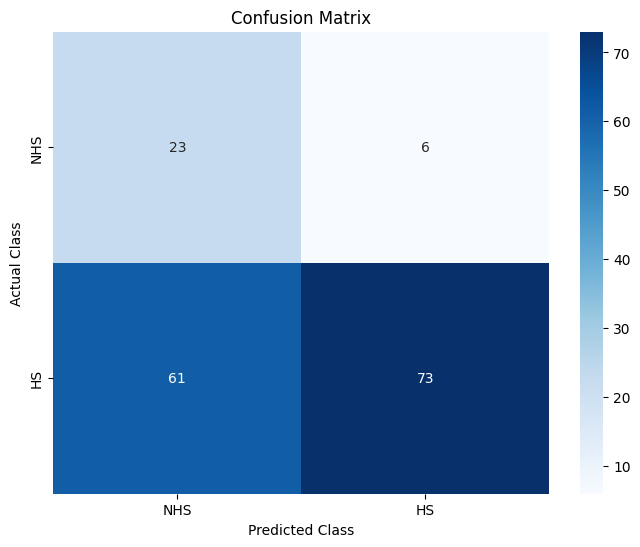

In [10]:

# Convert the 'Classification' and 'classification_dict' columns to numerical values
# Assuming 'HS' is positive (1) and 'NHS' is negative (0)
y_true = hate_speech_df['Classification'].map({'HS': 1, 'NHS': 0}).values
y_pred = hate_speech_df['classification_dict'].map({'HS': 1, 'NHS': 0}).values

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NHS', 'HS'], yticklabels=['NHS', 'HS'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()
